In [ ]:
import requests
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import nltk

In [ ]:
from textblob import Blobber
from textblob.sentiments import NaiveBayesAnalyzer

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
# По адресу страницы с отзывами на фильм возвращается датафрейм с отзывами и оценками 
def get_rating_reviews(url: str) -> pd.DataFrame():
  ajax_url = url.split('?')[0] + "/_ajax?paginationKey={}"
  reviews = []
  data = {"review": [], "rating": []}
  r = requests.get(url)
  soup = BeautifulSoup(r.content, 'html.parser')
  name = soup.find_all('div',{"class":"parent"})[0]
  print("Название фильма: ", name.find('a').get_text())
  while True:
      r = requests.get(url)
      soup = BeautifulSoup(r.content, 'html.parser') 
      for k in soup.find_all('div',{"class":"review-container"}):
          rating = k.find('span', class_='rating-other-user-rating')
          if rating:
              rating = ''.join(i.text for i in rating.find_all('span')[-2:])
              text = k.find('div', class_='text show-more__control').get_text()              
              reviews.append([rating, text])
              data["review"].append(text)
              data["rating"].append(rating)
          # print(rating, text)

      load_more = soup.find('div', class_='load-more-data')
      if not load_more:
          break
      url = ajax_url.format(load_more['data-key'])
  df = pd.DataFrame(data)
  df['rating'] = df['rating'].apply(lambda x: x if x is None else x[0])
  return df

In [ ]:
url = "https://www.imdb.com/title/tt5433138/reviews/?ref_=tt_ql_urv"

In [ ]:
urls = ["https://www.imdb.com/title/tt5433138/reviews/?ref_=tt_ql_urv", "https://www.imdb.com/title/tt4630562/reviews/?ref_=tt_ql_urv",
        "https://www.imdb.com/title/tt1596343/reviews/?ref_=tt_ql_urv", "https://www.imdb.com/title/tt0463985/reviews/?ref_=tt_ql_urv",
        "https://www.imdb.com/title/tt6806448/reviews/?ref_=tt_ql_urv"]

In [ ]:
def analyse(url):
  df = get_rating_reviews(url)
  tb = Blobber(analyzer=NaiveBayesAnalyzer())
  df['positive'] = df['review'].apply(lambda x: round(tb(x).sentiment.p_pos))
  df = df.sort_values(by='rating')
  plot_hist(df)
  sns.barplot(x='rating', y='positive', data=df)
  plt.show()
  plot_crosstab(df)
  make_chi_test(df)


In [ ]:
def plot_hist(df):
  df.rating.hist()
  plt.title('Распределение рейтинга')
  plt.xlabel('Рейтинг')
  plt.ylabel('Частота')
  plt.show()

In [ ]:
def plot_crosstab(df):
  %matplotlib inline
  pd.crosstab(df.rating,df.positive).plot(kind='bar')
  plt.title('Позитивность отзыва к рейтингу')
  plt.xlabel('Рейтинг')
  plt.ylabel('Частота')
  plt.show()

In [ ]:
# create contingency table
def make_chi_test(df2):
  data_crosstab = pd.crosstab(df2['rating'],
                              df2['positive'],
                            margins=True, margins_name="Total")
  data_crosstab
  # significance level
  alpha = 0.05

  # Calcualtion of Chisquare test statistics
  chi_square = 0
  rows = df2['rating'].unique()
  columns = df2['positive'].unique()
  for i in columns:
      for j in rows:     
          O = data_crosstab[i][j]
          E = data_crosstab[i]['Total'] * data_crosstab['Total'][j] / data_crosstab['Total']['Total']
          chi_square += (O-E)**2/E
  print("Проверка гипотезы о независимости уровня позитивности отзывы от рейтинга фильма")
  # The p-value approach
  print("Подход 1: p-value подход к проверке гипотезы:")
  p_value = 1 - stats.norm.cdf(chi_square, (len(rows)-1)*(len(columns)-1))
  conclusion = "Не отвергаем нулевую гипотезу"
  if p_value <= alpha:
      conclusion = "Отвергаем нулевую гипотезу"
          
  print("chisquare-score is:", chi_square, " and p value is:", p_value)
  print(conclusion)
      
  # The critical value approach
  print("\n--------------------------------------------------------------------------------------")
  print("Подход 2:critical value подход к проверке гипотезы:")
  critical_value = stats.chi2.ppf(1-alpha, (len(rows)-1)*(len(columns)-1))
  conclusion = "Не отвергаем нулевую гипотезу"
  if chi_square > critical_value:
      conclusion = "Отвергаем нулевую гипотезу"
          
  print("chisquare-score is:", chi_square, " and p value is:", critical_value)
  print(conclusion)

Название фильма:  Fast & Furious Presents: Hobbs & Shaw


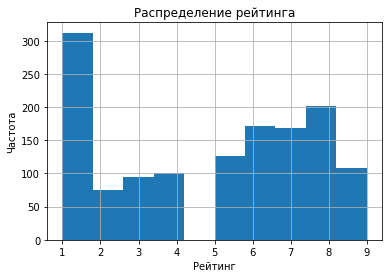

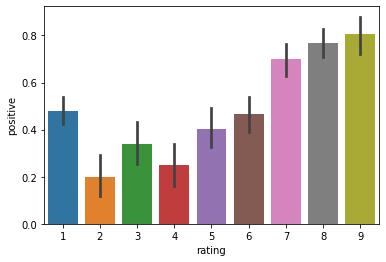

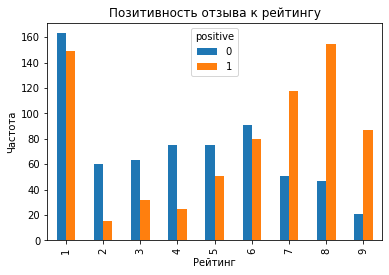

Проверка гипотезы о независимости уровня позитивности отзывы от рейтинга фильма
Подход 1: p-value подход к проверке гипотезы:
chisquare-score is: 189.9019621091568  and p value is: 0.0
Отвергаем нулевую гипотезу

--------------------------------------------------------------------------------------
Подход 2:critical value подход к проверке гипотезы:
chisquare-score is: 189.9019621091568  and p value is: 15.50731305586545
Отвергаем нулевую гипотезу


In [ ]:
analyse(urls[4])

Название фильма:  F9: The Fast Saga


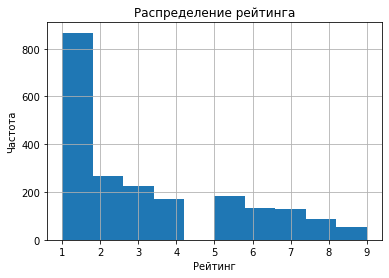

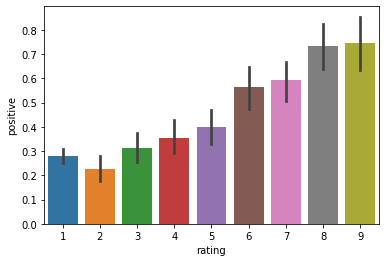

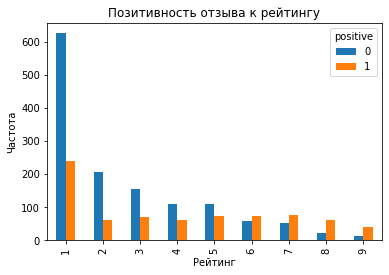

Проверка гипотезы о независимости уровня позитивности отзывы от рейтинга фильма
Подход 1: p-value подход к проверке гипотезы:
chisquare-score is: 191.29452394375718  and p value is: 0.0
Отвергаем нулевую гипотезу

--------------------------------------------------------------------------------------
Подход 2:critical value подход к проверке гипотезы:
chisquare-score is: 191.29452394375718  and p value is: 15.50731305586545
Отвергаем нулевую гипотезу
Название фильма:  The Fate of the Furious


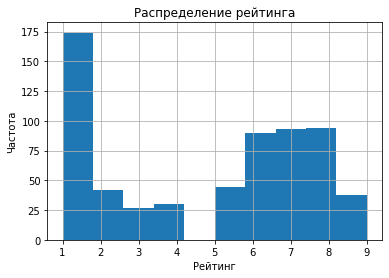

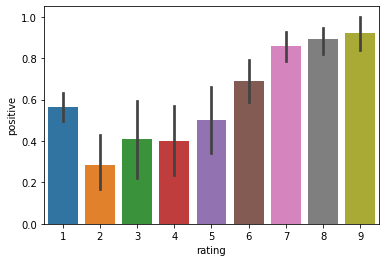

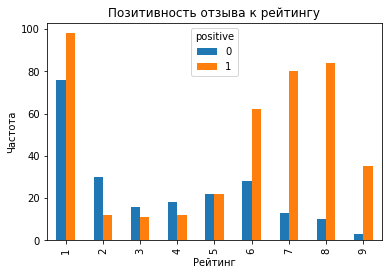

Проверка гипотезы о независимости уровня позитивности отзывы от рейтинга фильма
Подход 1: p-value подход к проверке гипотезы:
chisquare-score is: 106.29106533283253  and p value is: 0.0
Отвергаем нулевую гипотезу

--------------------------------------------------------------------------------------
Подход 2:critical value подход к проверке гипотезы:
chisquare-score is: 106.29106533283253  and p value is: 15.50731305586545
Отвергаем нулевую гипотезу
Название фильма:  Fast Five


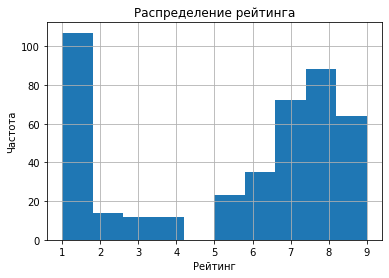

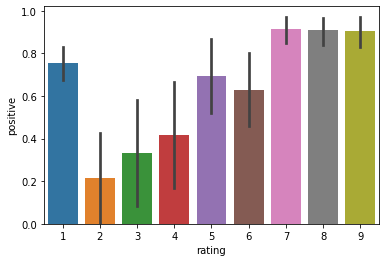

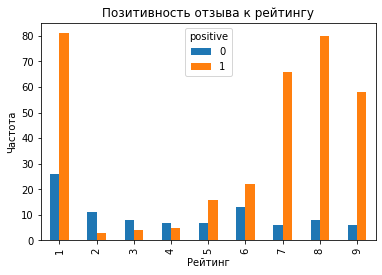

Проверка гипотезы о независимости уровня позитивности отзывы от рейтинга фильма
Подход 1: p-value подход к проверке гипотезы:
chisquare-score is: 78.70581925674387  and p value is: 0.0
Отвергаем нулевую гипотезу

--------------------------------------------------------------------------------------
Подход 2:critical value подход к проверке гипотезы:
chisquare-score is: 78.70581925674387  and p value is: 15.50731305586545
Отвергаем нулевую гипотезу
Название фильма:  The Fast and the Furious: Tokyo Drift


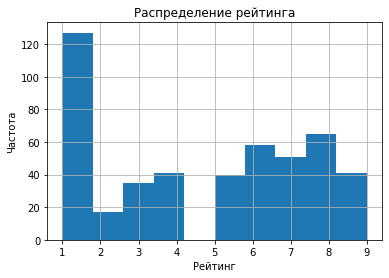

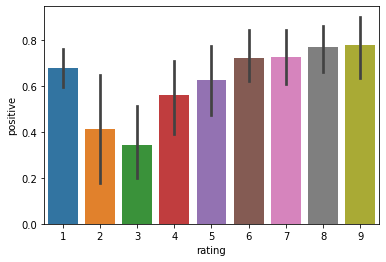

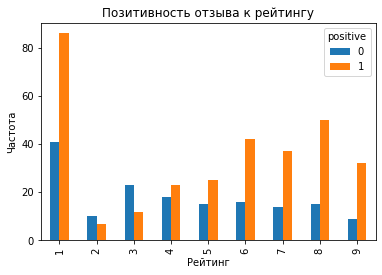

Проверка гипотезы о независимости уровня позитивности отзывы от рейтинга фильма
Подход 1: p-value подход к проверке гипотезы:
chisquare-score is: 30.722964539266766  and p value is: 0.0
Отвергаем нулевую гипотезу

--------------------------------------------------------------------------------------
Подход 2:critical value подход к проверке гипотезы:
chisquare-score is: 30.722964539266766  and p value is: 15.50731305586545
Отвергаем нулевую гипотезу
Название фильма:  Fast & Furious Presents: Hobbs & Shaw


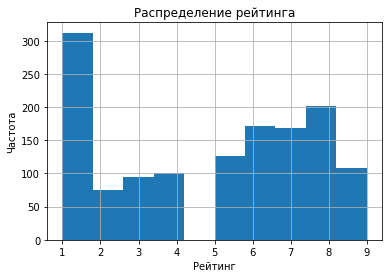

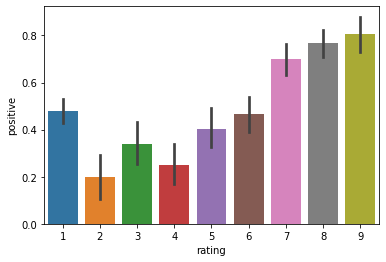

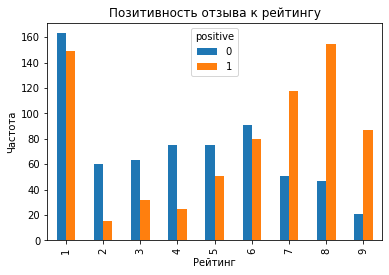

Проверка гипотезы о независимости уровня позитивности отзывы от рейтинга фильма
Подход 1: p-value подход к проверке гипотезы:
chisquare-score is: 189.9019621091568  and p value is: 0.0
Отвергаем нулевую гипотезу

--------------------------------------------------------------------------------------
Подход 2:critical value подход к проверке гипотезы:
chisquare-score is: 189.9019621091568  and p value is: 15.50731305586545
Отвергаем нулевую гипотезу


In [ ]:
for url in urls:
  analyse(url)

In [ ]:
nltk.download("movie_reviews")

[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Unzipping corpora/movie_reviews.zip.


True

In [ ]:
nltk.download("punkt")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
df.groupby('rating').pos.value_counts()

rating  pos
1       1      81
        0      26
2       0      11
        1       3
3       0       8
        1       4
4       0       7
        1       5
5       1      16
        0       7
6       1      22
        0      13
7       1      66
        0       6
8       1      80
        0       8
9       1      58
        0       6
Name: pos, dtype: int64

In [ ]:
df2 = df2.dropna()

In [ ]:
df2.rating = df2.rating.astype(int)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [ ]:
df2 = df2.sort_values(by='rating')

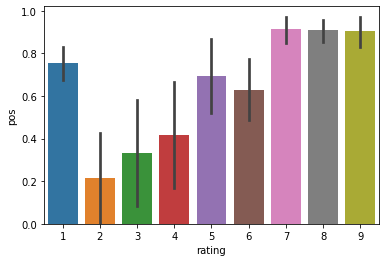

In [ ]:
sns.barplot(x='rating', y='pos', data=df2)

Text(0, 0.5, 'Частота')

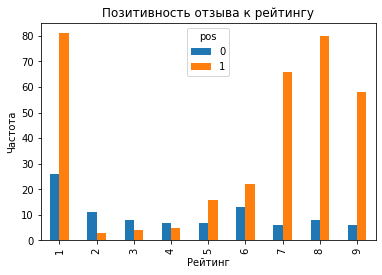

In [ ]:
%matplotlib inline
pd.crosstab(df2.rating,df2.pos).plot(kind='bar')
plt.title('Позитивность отзыва к рейтингу')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')

Text(0, 0.5, 'Частота')

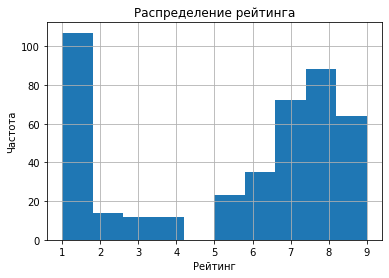

In [ ]:
df2.rating.hist()
plt.title('Распределение рейтинга')
plt.xlabel('Рейтинг')
plt.ylabel('Частота')

In [ ]:
from scipy import stats

In [ ]:
X = np.array(df2.rating)
y = np.array(df2.pos)
X = X.reshape(-1,1)

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train,y_train)

#
y_pred=logreg.predict(X_test)

In [ ]:
from sklearn.metrics import classification_report

array([[294,  42],
       [136,  59]])

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.88      0.77       336
           1       0.58      0.30      0.40       195

    accuracy                           0.66       531
   macro avg       0.63      0.59      0.58       531
weighted avg       0.65      0.66      0.63       531

